In [61]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.spatial import KDTree
import numpy as np


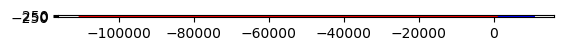

In [62]:
check_distance=250


# Step 1: Create a 20 random GeoPandas Point Series and 5 random GeoPandas Circle Polygon Series each of radius 100
#np.random.seed(0)


data_points = gpd.GeoDataFrame({'geometry': [Point(np.random.uniform(-100000, 10000), np.random.uniform(-100, 100)) for _ in range(700000)]})
#circle_center = gpd.GeoDataFrame({'geometry': [Point(np.random.uniform(-1000, 100), np.random.uniform(-10, 10)) for _ in range(30)]})

circle_center = gpd.GeoDataFrame({'geometry': [Point( -i*(110000/3000),np.random.uniform(-10, 10)) for i in range(3000)]}) #circle center are the transect points chosen

# Append 'wave height' column to circle_center
data_points['wave height'] = np.random.uniform(0.5, 7, len(data_points))




# buffer_circles = gpd.GeoDataFrame([Polygon(p.buffer(check_distance)) for p in circle_center[0][:5]])
buffer_circles = gpd.GeoDataFrame({'geometry': [Polygon(p.buffer(check_distance)) for p in circle_center['geometry']]})

#for square search instead
buffer_squares = gpd.GeoDataFrame({'geometry': [Polygon(p.buffer(check_distance, cap_style=3)) for p in circle_center['geometry']]})

#if you want values in meters, not necessary because distances are only used for weights
# data_points = data_points.to_crs('+proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
# circle_center = circle_center.to_crs('+proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
# buffer_circles= buffer_circles.to_crs('+proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

# Step 2: Visualize these 2 geospatial datasets on a map
fig, ax = plt.subplots()
data_points.plot(ax=ax, color='blue', markersize=10)
circle_center.plot(ax=ax, color='red', markersize=10)
buffer_circles.boundary.plot(ax=ax, color='red')
plt.show()


In [ ]:
weight_power=1 #idw weighting

In [63]:




# for i in range(0,len(buffer_circles['geometry'])):
#     inside_points = data_points[data_points.within(buffer_circles.iloc[i]['geometry'])]


#     # Calculate distance
#     #inside_points['distance'] = inside_points.geometry.distance(circle_center.geometry[0])
#     inside_points.loc[:,'distance'] = inside_points.geometry.distance(circle_center.geometry[i])


#     # Sort inside_points by 'distance' in ascending order
#     sorted_inside_points = inside_points.sort_values(by='distance')

#     # Select the top 2 rows
#     top_two_points = sorted_inside_points.head(2)


#     weights= 1/(top_two_points['distance']**weight_power)
   
#     numerator=np.sum(weights*top_two_points['wave height'])
#     denominator= np.sum(weights)
#     value=numerator/denominator
#     #print(value)

#     circle_center.at[i,'sampled points']=len(inside_points['geometry'])
#     circle_center.at[i,'interpolated wave height']=value


In [64]:
for i in range(0,len(buffer_circles['geometry'])):
    #inside_points = data_points[data_points.within(buffer_circles.iloc[i]['geometry'])]
    inside_points = data_points[data_points.within(buffer_circles.loc[i,'geometry'])]
    # Calculate distance
    inside_points.loc[:,'distance'] = inside_points.geometry.distance(circle_center.geometry[i])

    # Sort inside_points by 'distance' in ascending order
    sorted_inside_points = inside_points.sort_values(by='distance')

    # Select the top 2 rows
    top_two_points = sorted_inside_points.head(2)

    if len(inside_points['geometry'])<1:
            circle_center.loc[i,'sampled points']=0
            circle_center.loc[i,'interpolated wave height']=0
            continue
    
    if len(inside_points['geometry'])<2:
        circle_center.loc[i,'sampled points']=1
        circle_center.loc[i,'interpolated wave height']=top_two_points['wave height']
        continue

    weights= 1/(top_two_points['distance']**weight_power)
   
    numerator=np.sum(weights*top_two_points['wave height'])
    denominator= np.sum(weights)

    # Check if denominator is zero before division
    if denominator != 0:
        value=numerator/denominator
    else:
        value = None # Or any other value you want to assign when denominator is zero

    # Use .loc to avoid SettingWithCopyWarning
    circle_center.loc[i,'sampled points']=len(inside_points['geometry'])
    circle_center.loc[i,'interpolated wave height']=value

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be s

In [65]:
circle_center

,geometry,sampled points,interpolated wave height
0,POINT (0.000 1.440),3068.0,4.886828
1,POINT (-36.667 -7.775),3061.0,2.118679
2,POINT (-73.333 -7.254),3007.0,2.786096
3,POINT (-110.000 3.469),3054.0,3.506637
4,POINT (-146.667 -0.107),3084.0,5.299172
...,...,...,...
2995,POINT (-109816.667 4.201),0.0,0.000000
2996,POINT (-109853.333 -8.952),0.0,0.000000
2997,POINT (-109890.000 1.597),0.0,0.000000
2998,POINT (-109926.667 -6.109),0.0,0.000000


In [66]:
circle_center.describe()

,sampled points,interpolated wave height
count,3000.000000,3000.000000
mean,2811.033000,3.459009
std,886.118075,1.711359
min,0.000000,0.000000
25%,3039.000000,2.370850
50%,3085.000000,3.587021
75%,3126.000000,4.736393
max,3278.000000,6.967081


# Also possible to use Kmeans for example

# Create a DataFrame with coordinates and corresponding values
data = {'latitude': [40.7128, 34.0522, 41.8781],
        'longitude': [-74.0060, -118.2437, -87.6298],
        'value': [10, 15, 20]}
df = pd.DataFrame(data)

print(df)

from sklearn.neighbors import KNeighborsRegressor

# Reshape the DataFrame to a 2D array
X = df[['latitude', 'longitude']].values.reshape(-1, 2)
y = df['value'].values

# Create and fit the model
model = KNeighborsRegressor(n_neighbors=3, weights='distance')
model.fit(X, y)

# Define new points where you want to interpolate values
new_points = [[40.7128, -74.0060], [34.0522, -118.2437], [41.8781, -87.6298]]

# Predict values at new points
new_values = model.predict(new_points)

print(new_values)